<a id = "table_of_contents"></a>
##  Table of Contents

[Importing the necessary libraries](#1)  
[Getting and joining the datasets](#2)  
[Printing the first 5 rows](#3)  
[Dropping useless columns](#4)  
[Info of the dataframe](#5)  
[Number of observations in categorical variables](#6)  
[Statistical summary of numerial variables](#7)  
[Histogram of the variables](#8)  
[Separeting the data into train and test sets using stratified sampling](#9)  
[Visualization of categorical variables](#10)  
[Correlation matrix](#11)  
[Separeting dependent and independent variables in the train set](#12)  
[Transformer that encodes categorical variables  into numerical form](#13)  
[Applying our transformer first, filling missing values with median and scaling our dataset using a pipeline](#14)  
[Comparing the models with k-fold CV](#15)  
[A class for applying k-fold CV toghether with PCA](#16)  
[Comparing the models with first PCA and then k-fold CV](#17)  
[Fine tuning](#18)  
[Evaluating the performance of the model on test set](#19)  
[Confusion matrix](#20)  
[Classification report (precision, recall etc...)](#21)  
[ROC - Receiver operating characteristic curve](#22)  
[ROC AUC score - area under the receiver operating characteristic curve](#23)  

<a id = "1"></a>
# Importing the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from pandas.plotting import table
from random import randrange
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings("ignore")

<a id = "2"></a>
# Getting and joining the datasets

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
data = pd.concat([train, test])

<a id = "3"></a>
# Printing the first 5 rows

In [3]:
data.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


<a id = "4"></a>
# Dropping useless columns

In [4]:
data.drop(["id", "Unnamed: 0"], axis=1, inplace=True)

<a id = "5"></a>
# Info of the dataframe

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129880 entries, 0 to 25975
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Gender                             129880 non-null  object 
 1   Customer Type                      129880 non-null  object 
 2   Age                                129880 non-null  int64  
 3   Type of Travel                     129880 non-null  object 
 4   Class                              129880 non-null  object 
 5   Flight Distance                    129880 non-null  int64  
 6   Inflight wifi service              129880 non-null  int64  
 7   Departure/Arrival time convenient  129880 non-null  int64  
 8   Ease of Online booking             129880 non-null  int64  
 9   Gate location                      129880 non-null  int64  
 10  Food and drink                     129880 non-null  int64  
 11  Online boarding                    12988

<a id = "6"></a>
# Number of observations in categorical variables

In [6]:
for column in data:
    if len(np.unique(data[column])) < 10:
        print(data[column].value_counts(), "\n")

Female    65899
Male      63981
Name: Gender, dtype: int64 

Loyal Customer       106100
disloyal Customer     23780
Name: Customer Type, dtype: int64 

Business travel    89693
Personal Travel    40187
Name: Type of Travel, dtype: int64 

Business    62160
Eco         58309
Eco Plus     9411
Name: Class, dtype: int64 

2    32320
3    32185
4    24775
1    22328
5    14356
0     3916
Name: Inflight wifi service, dtype: int64 

4    31880
5    27998
3    22378
2    21534
1    19409
0     6681
Name: Departure/Arrival time convenient, dtype: int64 

3    30393
2    30051
4    24444
1    21886
5    17424
0     5682
Name: Ease of Online booking, dtype: int64 

3    35717
4    30466
2    24296
1    21991
5    17409
0        1
Name: Gate location, dtype: int64 

4    30563
5    27957
3    27794
2    27383
1    16051
0      132
Name: Food and drink, dtype: int64 

4    38468
3    27117
5    26020
2    21934
1    13261
0     3080
Name: Online boarding, dtype: int64 

4    39756
5    33158
3   

<a id = "7"></a>
# Statistical summary of numerial variables

In [7]:
data.describe()

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
count,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129880.000000,129487.000000
mean,39.427957,1190.316392,2.728696,3.057599,2.756876,2.976925,3.204774,3.252633,3.441361,3.358077,3.383023,3.350878,3.632114,3.306267,3.642193,3.286326,14.713713,15.091129
std,15.119360,997.452477,1.329340,1.526741,1.401740,1.278520,1.329933,1.350719,1.319289,1.334049,1.287099,1.316252,1.180025,1.266185,1.176669,1.313682,38.071126,38.465650
min,7.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000
50%,40.000000,844.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000
75%,51.000000,1744.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000
max,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000


<a id = "8"></a>
# Histogram of the variables

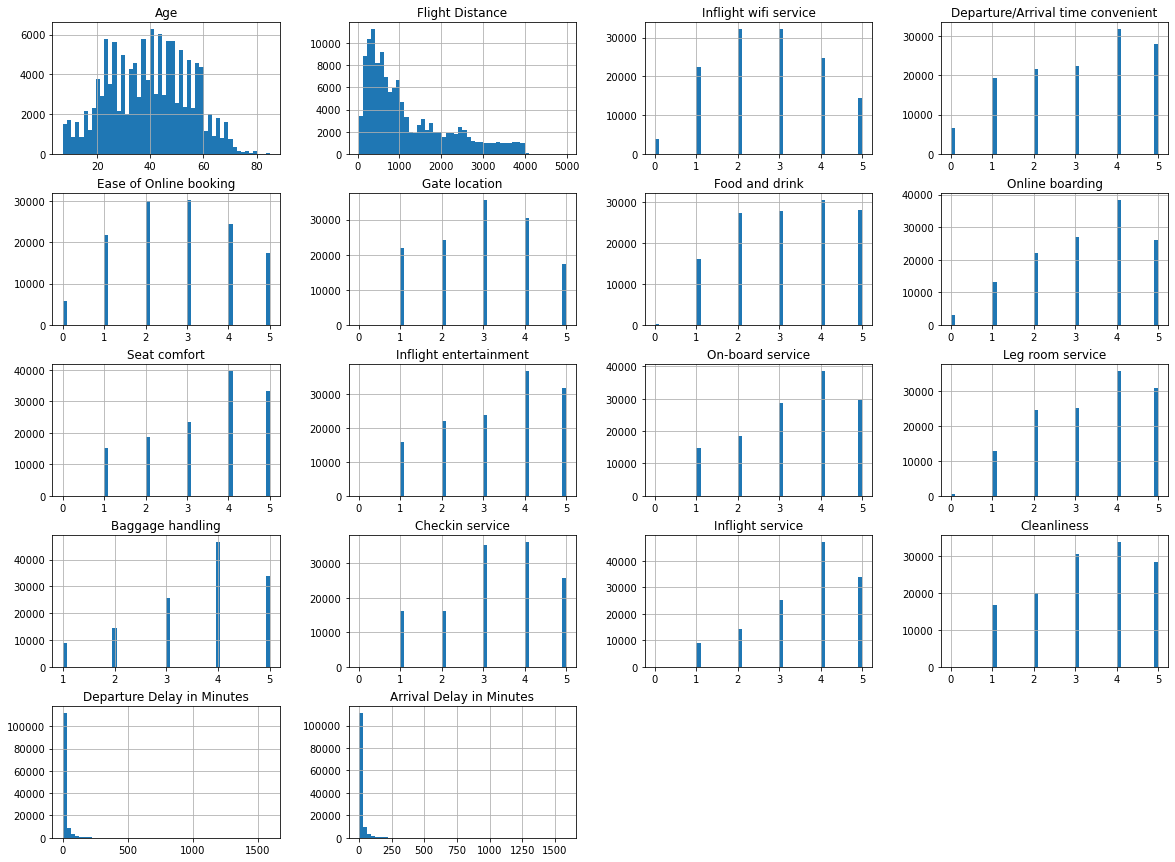

In [8]:
data.hist(bins=50, figsize=(20,15))
plt.show()

<a id = "9"></a>
# Separeting the data into train and test sets using stratified sampling

In [9]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(data, data['satisfaction']):
    strat_train_set = data.iloc[train_index]
    strat_test_set = data.iloc[test_index]

<a id = "10"></a>
# Visualization of categorical variables

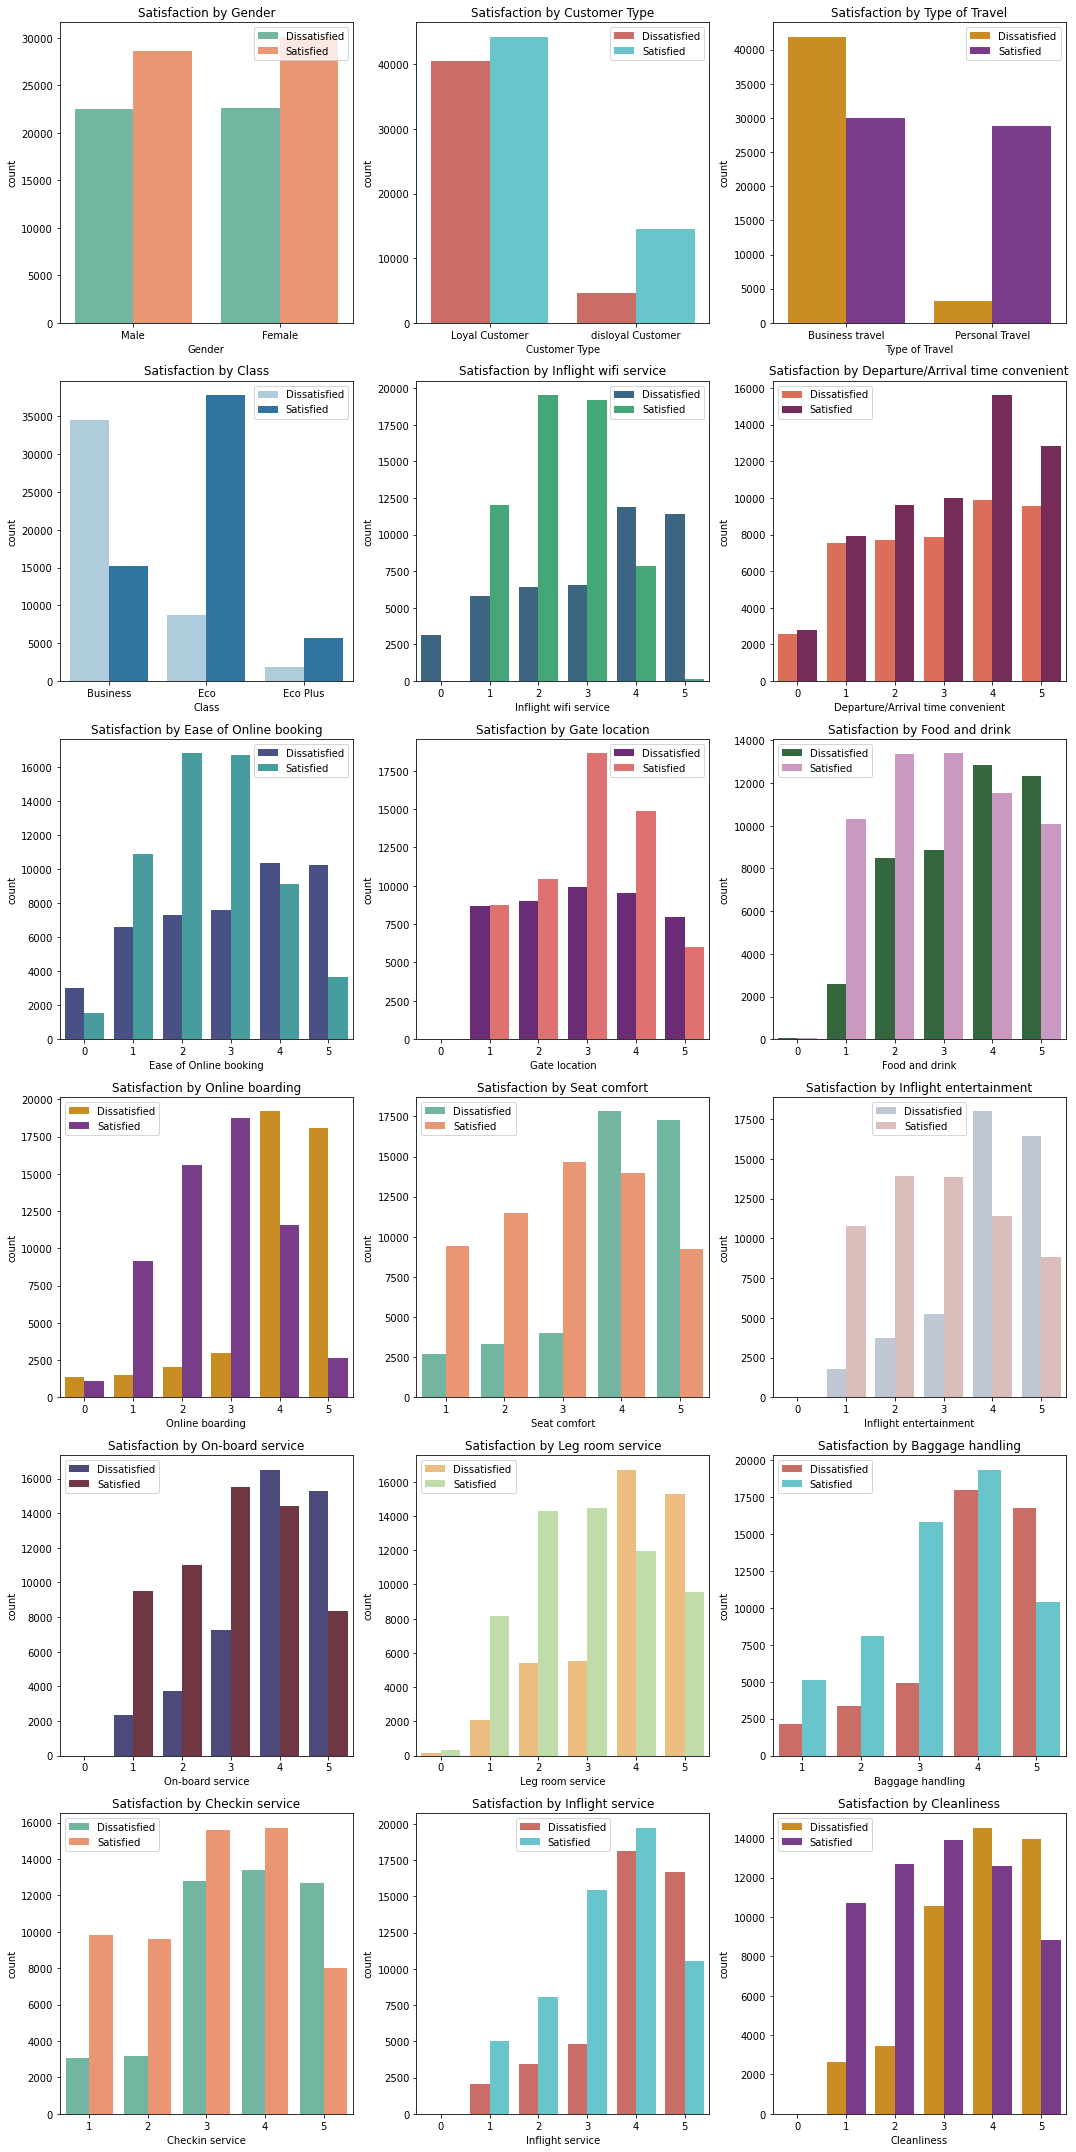

In [10]:
categorical = [column for column in strat_train_set if len(np.unique(strat_train_set[column]))<10 and column != 'satisfaction']
palettes = ["Set2", "hls", "CMRmap_r", "Paired", "viridis", "rocket_r", "mako", "magma", "cubehelix", "CMRmap_r","Set2", "vlag",
            "icefire", "Spectral", "hls", "Set2", "hls", "CMRmap_r"]

plt.figure(figsize=(15,30))
for i, variable in enumerate(categorical):
    plt.subplot(6, 3, i+1)
    sns.countplot(data=strat_train_set, x=variable , hue="satisfaction", palette=palettes[i])
    plt.title("Satisfaction by " + variable)
    plt.legend(labels=["Dissatisfied", "Satisfied"])

plt.tight_layout()
plt.show()

<a id = "11"></a>
# Correlation matrix

<AxesSubplot:>

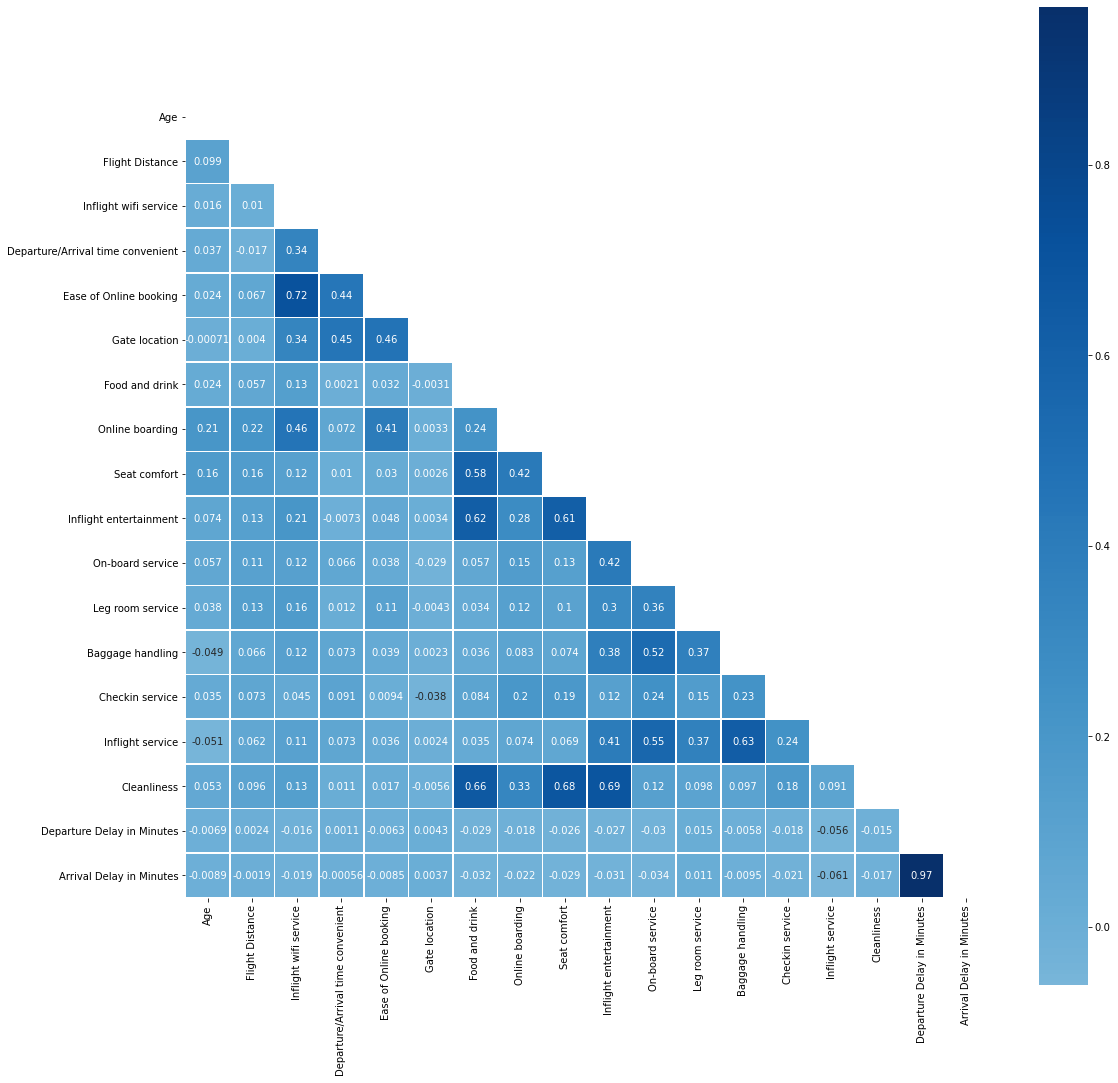

In [11]:
corr_matrix = strat_train_set.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
fig, ax = plt.subplots(figsize=(18, 18))
sns.heatmap(corr_matrix, mask=mask, cmap="Blues", vmax=None, center=0, square=True, annot=True, linewidths=.5)

<a id = "12"></a>
# Separeting dependent and independent variables in the train set

In [26]:
X_train = strat_train_set.drop("satisfaction", axis=1)
y_train = np.where(strat_train_set["satisfaction"] == "satisfied", 1, 0)

<a id = "13"></a>
# Transformer that encodes categorical variables  into numerical form

In [27]:
class convert_to_numeric(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.ordinal_encoder = OrdinalEncoder()
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        for column in X:
            if len(np.unique(X[column])) < 10 and type(X[column].iloc[0]) == str:
                reshaped = X[column].values.reshape(-1,1)
                X[column] = self.ordinal_encoder.fit_transform(reshaped)
        return(X)

<a id = "14"></a>
# Applying our transformer first, filling missing values with median and scaling our dataset using a pipeline

In [28]:
pipeline = Pipeline([
    ('to_numeric', convert_to_numeric()),
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler())
 ])

pipeline.fit(X_train)
X_train = pipeline.transform(X_train)

<a id = "15"></a>
# Comparing the models with k-fold CV

[16:55:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:55:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:55:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:55:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

No handles with labels found to put in legend.


<AxesSubplot:title={'center':'Model Performances'}, xlabel='Algotithm', ylabel='CV Scores'>

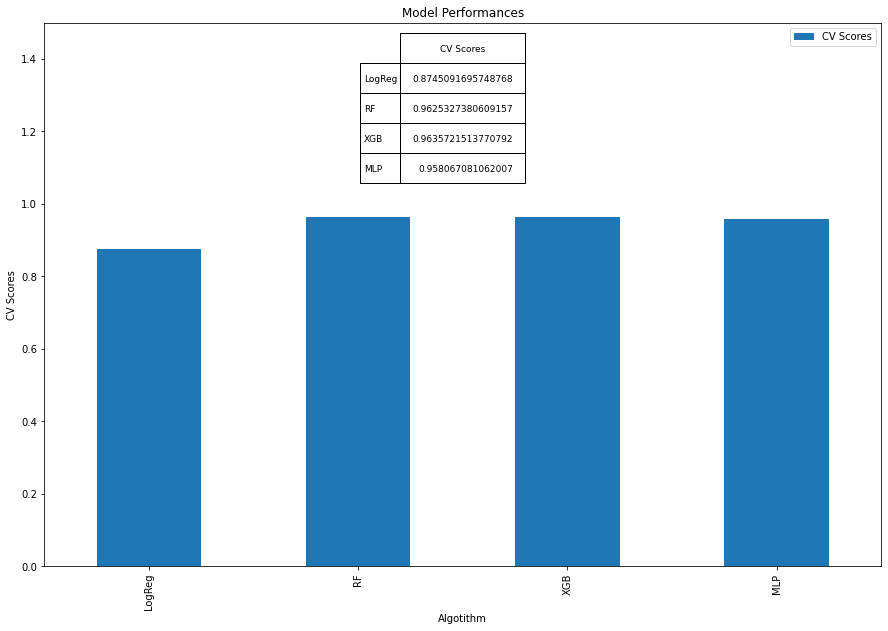

In [15]:
def fit_classifiers(X_train, y_train):
    
    # Adding sklearn classifiers into a list
    classifiers = []
    
    model1 = LogisticRegression()
    classifiers.append(model1) 
    model2 = RandomForestClassifier()
    classifiers.append(model2)
    model3 = xgboost.XGBClassifier()
    classifiers.append(model3)
    model4 = MLPClassifier()
    classifiers.append(model4)

    clfs = ["LogReg", "RF", "XGB", "MLP"]
    df = pd.DataFrame(index=clfs, columns=["CV Scores"])
    
    # Fitting the machine learning algorithms
    row = 0
    for clf in classifiers:
        scores = cross_val_score(clf, X_train, y_train, cv=5)
        mean = scores.mean()
        df["CV Scores"][row] = mean
        row += 1
    return(df)

# Calling the function
result = fit_classifiers(X_train, y_train)

# Plotting the results
fig, ax = plt.subplots(1, 1)
table(ax, np.round(result), loc="upper center", colWidths=[0.15, 0.15, 0.15])
ax.legend(loc='upper left')
ax.set_ylabel('CV Scores')
ax.set_xlabel('Algotithm')
ax.set_title('Model Performances')
result.plot(ax=ax, kind="bar", figsize=(15, 10), ylim=(0, 1.5))

<a id = "16"></a>
# A class for applying k-fold CV toghether with PCA

In [16]:
class kFoldCV:

    def __init__(self):
        pass
    
    def crossValSplit(self, dataset, numFolds):
        dataSplit = list()
        dataCopy = list(dataset)
        foldSize = int(len(dataset) / numFolds)
        for _ in range(numFolds):
            fold = list()
            while len(fold) < foldSize:
                index = randrange(len(dataCopy))
                fold.append(list(dataCopy.pop(index)))
            dataSplit.append(fold)
        return dataSplit
    
    def kFPredict(self, clf, dataset, numFolds, n_components):
        folds = self.crossValSplit(dataset, numFolds)
        preds = list()
        actuals = list()
        for fold in folds:
            trainSet = list(folds)
            trainSet.remove(fold) 
            trainSet = sum(trainSet, [])
            testSet = list()
            for row in fold:
                rowCopy = list(row)
                testSet.append(rowCopy)
                
            trainLabels = [row[-1] for row in trainSet]
            trainSet = [train[:-1] for train in trainSet]
            
            pca = PCA(n_components=n_components)
            pca.fit(trainSet)
            trainSet = pca.transform(trainSet)
            
            actual = [row[-1] for row in testSet]
            actuals.append(actual)
            testSet = [test[:-1] for test in testSet]
            testSet = pca.transform(testSet)
            
            clf.fit(trainSet, trainLabels)
            predicted = clf.predict(testSet)
            preds.append(predicted)
        return(actuals, preds)
    
    def kFCVEvaluate(self, clf, dataset, numFolds, n_components):
        actuals, preds = self.kFPredict(clf, dataset, numFolds, n_components)
        scores = list()
        for actual, predicted in zip(actuals, preds):
            score = accuracy_score(actual, predicted)
            scores.append(score)
        return(scores)

<a id = "17"></a>
# Comparing the models with first PCA and then k-fold CV

[17:03:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:04:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:04:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:04:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

No handles with labels found to put in legend.


<AxesSubplot:title={'center':'Model Performances'}, xlabel='Algorithm', ylabel='CV Scores'>

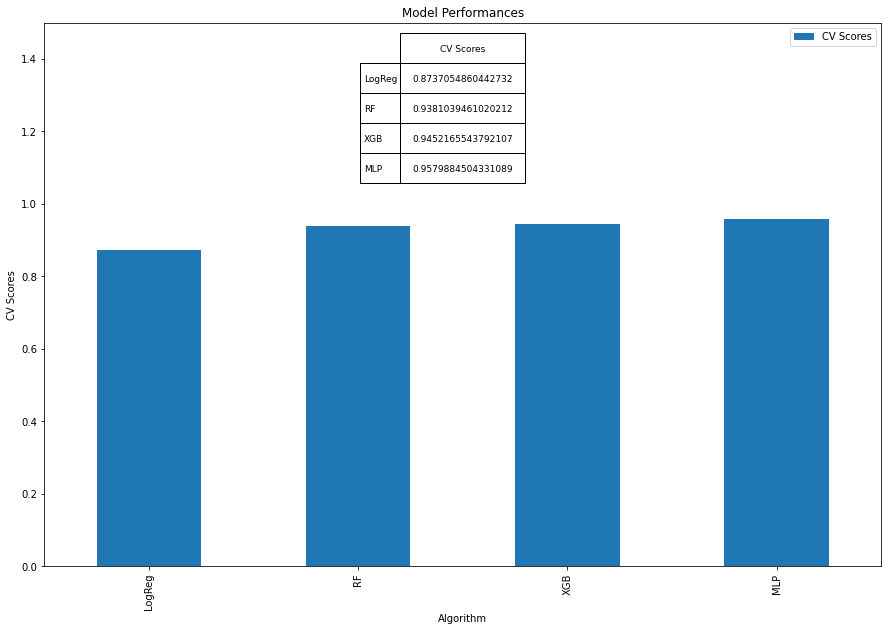

In [17]:
def fit_classifiers(X_train, y_train):
    dataset = np.concatenate((X_train, y_train.reshape(np.shape(X_train)[0], 1)), axis=1)
    
    # Adding sklearn classifiers into a list
    classifiers = []
    
    model1 = LogisticRegression()
    classifiers.append(model1) 
    model2 = RandomForestClassifier()
    classifiers.append(model2)
    model3 = xgboost.XGBClassifier()
    classifiers.append(model3)
    model4 = MLPClassifier()
    classifiers.append(model4)

    clfs = ["LogReg", "RF", "XGB", "MLP"]
    df = pd.DataFrame(index=clfs, columns=["CV Scores"])
    
    # Fitting the machine learning algorithms
    row = 0
    for clf in classifiers:
        kfcv = kFoldCV()
        scores = kfcv.kFCVEvaluate(clf=clf, dataset=dataset, numFolds=5, n_components=20)
        mean = (sum(scores)/float(len(scores)))
        df["CV Scores"][row] = mean
        row += 1
    return(df)

# Calling the function
result = fit_classifiers(X_train, y_train)

# Plotting the results
fig, ax = plt.subplots(1, 1)
table(ax, np.round(result), loc="upper center", colWidths=[0.15, 0.15, 0.15])
ax.legend(loc='upper left')
ax.set_ylabel('CV Scores')
ax.set_xlabel('Algorithm')
ax.set_title('Model Performances')
result.plot(ax=ax, kind="bar", figsize=(15, 10), ylim=(0, 1.5))

<a id = "18"></a>
# Fine tuning

In [21]:
# Function for fine tuning using Random Search
def optimizer(X, y, estimator, param_grid):
    
    search = RandomizedSearchCV(estimator,
                                param_grid,
                                n_iter=30,
                                cv=5,
                                random_state=1)
    grid_result = search.fit(X, y)
    print("\n", "Best: %f using %s" % (grid_result.best_score_,
                                 grid_result.best_params_))
    return(grid_result)

# Defining the model and hyper-parameters
selected_model = xgboost.XGBClassifier()
param_grid = {'eval_metric': ["logloss"],
              'n_estimators': [100, 150, 200, 250, 300],
              'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
              'max_depth': range(1, 100, 5),
              'colsample_bytree': [i/10.0 for i in range(1, 3)],
              'gamma': [i/10.0 for i in range(3)]}

# Calling the function
random_search = optimizer(X_train, y_train, selected_model, param_grid)


 Best: 0.955661 using {'n_estimators': 250, 'max_depth': 61, 'learning_rate': 0.3, 'gamma': 0.2, 'eval_metric': 'logloss', 'colsample_bytree': 0.2}


<a id = "19"></a>
# Evaluating the performance of the model on test set

In [29]:
# Separeting dependent and independent variables in the test set
X_test = strat_test_set.drop("satisfaction", axis=1)
y_test = np.where(strat_test_set["satisfaction"] == "satisfied", 1, 0)

# Transforming the test set
X_test = pipeline.transform(X_test)

# Fitting the model
clf = xgboost.XGBClassifier(n_estimators=250,
                            max_depth=61,
                            learning_rate=0.3,
                            gamma=0.2,
                            eval_metric='logloss',
                            colsample_bytree=0.2)
clf.fit(X_train, y_train)

# Accuracy score
accuracy = clf.score(X_test, y_test)
print("\n", accuracy)


 0.9558438558669541


<a id = "20"></a>
# Confusion matrix

In [30]:
print(confusion_matrix(y_test, (clf.predict(X_test))))

[[14271   419]
 [  728 10558]]


<a id = "21"></a>
# Classification report (precision, recall etc...)

In [31]:
print(classification_report(y_test, (clf.predict(X_test))))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96     14690
           1       0.96      0.94      0.95     11286

    accuracy                           0.96     25976
   macro avg       0.96      0.95      0.95     25976
weighted avg       0.96      0.96      0.96     25976



<a id = "22"></a>
# ROC - Receiver operating characteristic curve

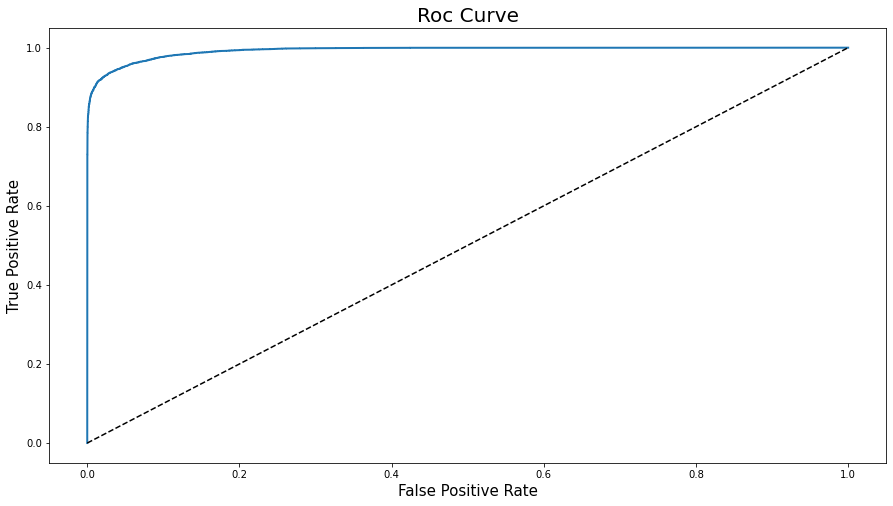

In [32]:
fpr, tpr, thresholds = roc_curve(y_test, (clf.predict_proba(X_test)[:, 1]))

def plot_roc_curve(fpr, tpr, label=None):
    plt.figure(figsize=(15, 8))
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('Roc Curve', fontsize=20)
    plt.xlabel('False Positive Rate', fontsize=15)
    plt.ylabel('True Positive Rate', fontsize=15)
plot_roc_curve(fpr, tpr)
plt.show()

<a id = "23"></a>
# ROC AUC score - area under the receiver operating characteristic curve

In [33]:
roc_auc_score(y_test, (clf.predict_proba(X_test)[:, 1]))

0.9925617104005552